# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:50px;;padding:20px;font-weight:bold">Energy Time Series Data <p/> 
## The data can be found here: [Central Hudson](https://www.cenhud.com/dg)

In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

In [72]:
years_list_hist = list(np.arange(2015,2020,1))
years_hist = [str(year) for year in years_list_hist]

years_list_fut = list(np.arange(2020,2026,1))
years_fut = [str(year) for year in years_list_fut]
print(years_hist)
print(years_fut)

['2015', '2016', '2017', '2018', '2019']
['2020', '2021', '2022', '2023', '2024', '2025']


In [95]:
temp = pd.read_excel('energy_data.xlsx', sheet_name='2015', usecols=[1,2,3,4,5,6])
temp.head()

,year,month,date,hour,tempf_historical,load_historical
0,2015,1,2015-01-01,1,23.00,5.928991
1,2015,1,2015-01-01,2,24.08,5.663623
2,2015,1,2015-01-01,3,24.08,5.492268
3,2015,1,2015-01-01,4,24.98,5.292946
4,2015,1,2015-01-01,5,24.98,5.328747


In [96]:
pd.to_datetime(temp['hour'],format='%H', unit=)

ValueError: unconverted data remains: 4

In [103]:
temp['time'] = temp['date']+pd.to_timedelta(temp['hour'], unit='hours' )

In [104]:
temp.head()

,year,month,date,hour,tempf_historical,load_historical,time
0,2015,1,2015-01-01,1,23.00,5.928991,2015-01-01 01:00:00
1,2015,1,2015-01-01,2,24.08,5.663623,2015-01-01 02:00:00
2,2015,1,2015-01-01,3,24.08,5.492268,2015-01-01 03:00:00
3,2015,1,2015-01-01,4,24.98,5.292946,2015-01-01 04:00:00
4,2015,1,2015-01-01,5,24.98,5.328747,2015-01-01 05:00:00


In [106]:
hist_df = []
fut_df = []

# Create df for historical data 2015-2019

for year in years_hist:
    df_temp = pd.read_excel('energy_data.xlsx', sheet_name=year, usecols=[1,2,3,4,5,6])
    hist_df.append(df_temp)
    
df = pd.concat(hist_df)
df = df.reset_index(drop=True)
df['time'] = df['date']+pd.to_timedelta(df['hour'], unit='hours')
df = df.set_index('time')


# Create df for prediction data 2020-2025
for year in years_fut:
    df_temp = pd.read_excel('energy_data.xlsx', sheet_name=year, usecols=[1,2,3,4,18])
    fut_df.append(df_temp)

df_fut = pd.concat(fut_df)
df_fut = df_fut.reset_index(drop=True)
df_fut['time'] = df_fut['date']+pd.to_timedelta(df_fut['hour'], unit='hours')
df_fut = df_fut.set_index('time')


In [107]:
df.head()

,year,month,date,hour,tempf_historical,load_historical
time,,,,,,
2015-01-01 01:00:00,2015,1,2015-01-01,1,23.00,5.928991
2015-01-01 02:00:00,2015,1,2015-01-01,2,24.08,5.663623
2015-01-01 03:00:00,2015,1,2015-01-01,3,24.08,5.492268
2015-01-01 04:00:00,2015,1,2015-01-01,4,24.98,5.292946
2015-01-01 05:00:00,2015,1,2015-01-01,5,24.98,5.328747


In [305]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [306]:
df_new = create_features(df)

col_order = ['date','year','quarter','month','dayofweek','hour','dayofmonth',
           'dayofyear','weekofyear','tempf_historical', 'load_historical']

df_new = df_new[col_order]
df_new['weekofyear'] = df_new['weekofyear'].astype(int)
df_new.head()

,date,year,quarter,month,dayofweek,hour,dayofmonth,dayofyear,weekofyear,tempf_historical,load_historical
time,,,,,,,,,,,
2015-01-01 01:00:00,2015-01-01,2015,1,1,3,1,1,1,1,23.00,5.928991
2015-01-01 02:00:00,2015-01-01,2015,1,1,3,2,1,1,1,24.08,5.663623
2015-01-01 03:00:00,2015-01-01,2015,1,1,3,3,1,1,1,24.08,5.492268
2015-01-01 04:00:00,2015-01-01,2015,1,1,3,4,1,1,1,24.98,5.292946
2015-01-01 05:00:00,2015-01-01,2015,1,1,3,5,1,1,1,24.98,5.328747


# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;;padding:10px;font-weight:bold">Visualizing the Data <p/> 

    The data is split into two parts. Historical energy data for 2015-2019, and the predicted energy data for 2020-2025. The goal is to train a model on the historical. Then get some prediction data and see how it compares with the predictions already made by the company. But first, let's visualize the data!

## First, let's look at the full historical data:

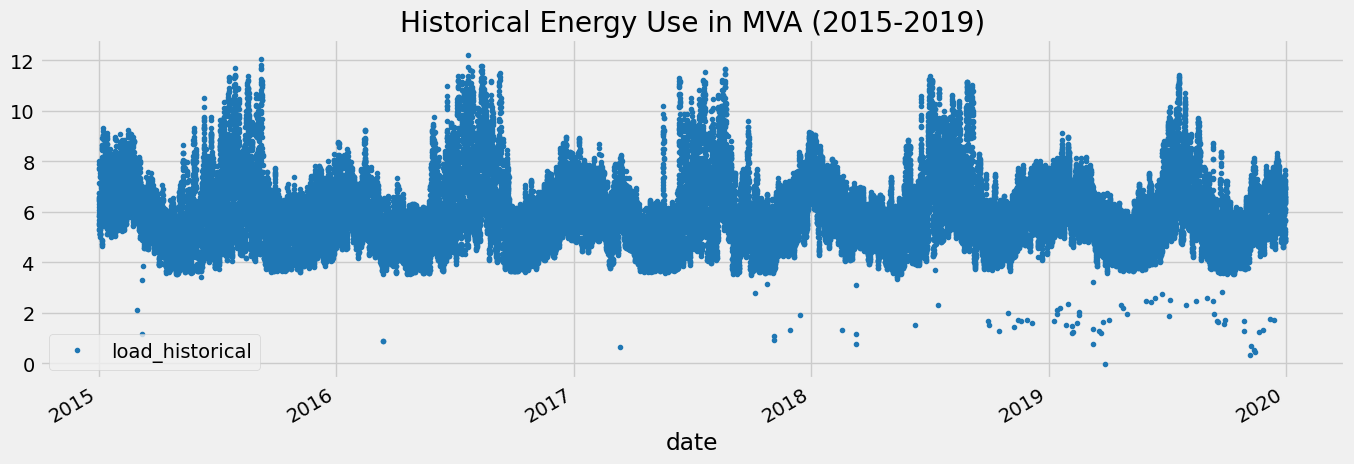

In [80]:
df.plot(y='load_historical',
        use_index=True,
        style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Historical Energy Use in MVA (2015-2019)')
plt.show()

## Example week of energy use: 2/1/2015 - 2/7/2015

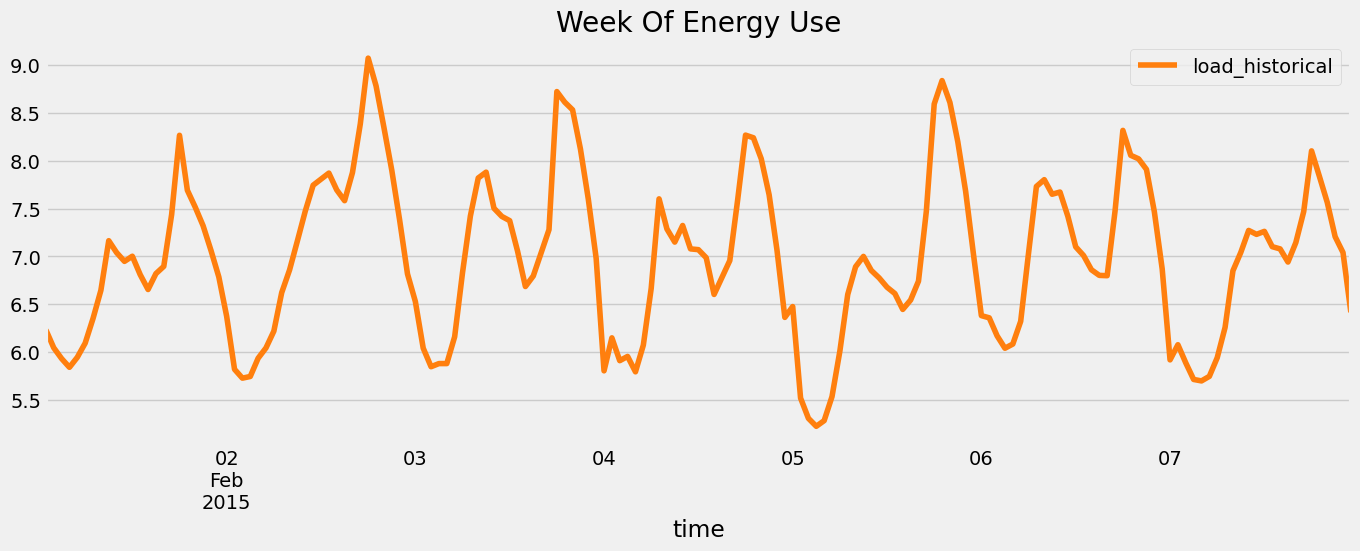

In [126]:
df.loc[(df.index > '02-01-2015') & (df.index < '02-08-2015')] \
    .plot(y='load_historical', use_index=True,figsize=(15, 5), title='Week Of Energy Use', color=color_pal[1])
plt.show()

## Example Day of energy use: 2/1/2015

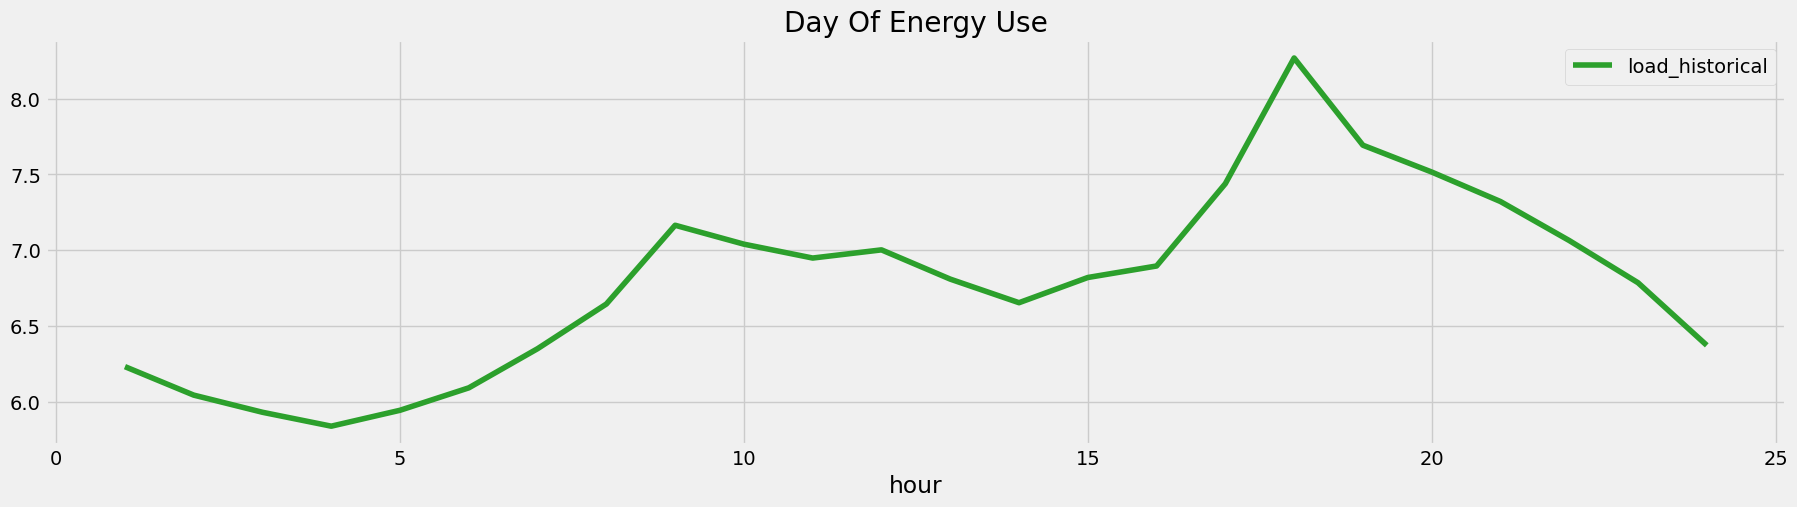

In [127]:
df.loc[(df['date'] == '02-01-2015')] \
    .plot(y='load_historical',x='hour',figsize=(20, 5), title='Day Of Energy Use',color=color_pal[2])
plt.show()

## Projected Energy use for 2020-2025:

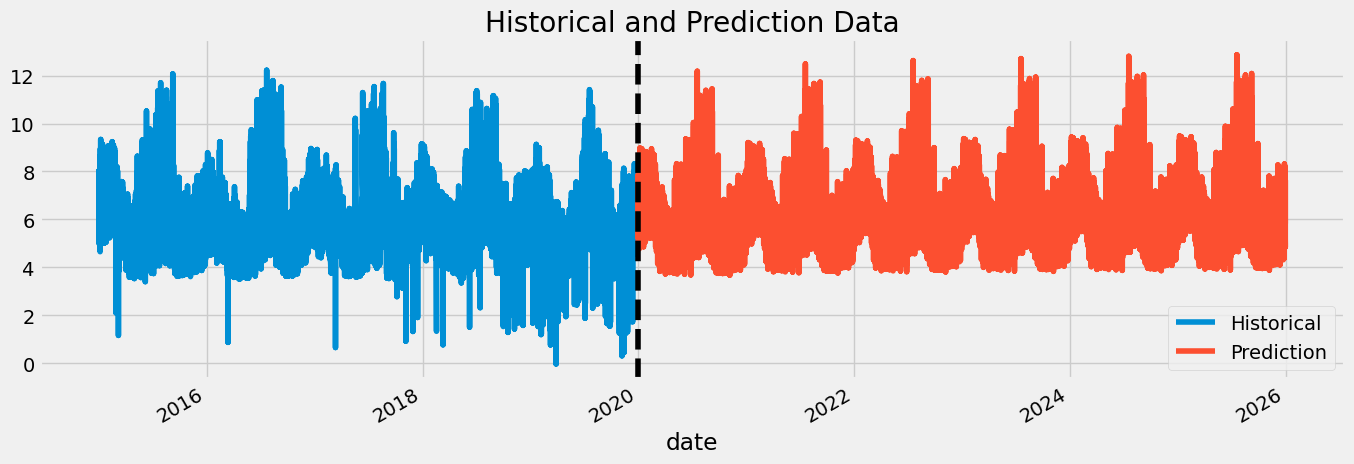

In [79]:
fig, ax = plt.subplots(figsize=(15, 5))
df.plot(y='load_historical',use_index=True, ax=ax, label='Historical Data', title='Historical and Prediction Data')
df_fut.plot(y='load_p99', use_index=True, ax=ax, label='Predicition Data')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Historical', 'Prediction'])
plt.show()

## Relationship between our Features and Target:

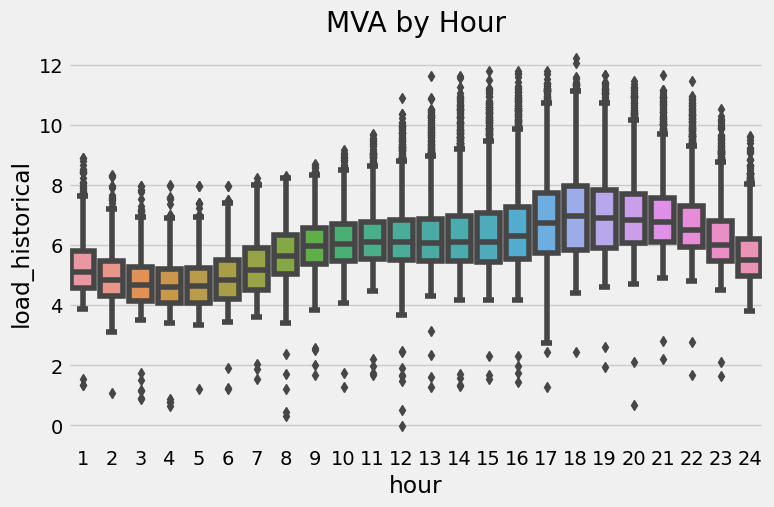

In [133]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_new, x='hour', y='load_historical')
ax.set_title('MVA by Hour')
plt.show()

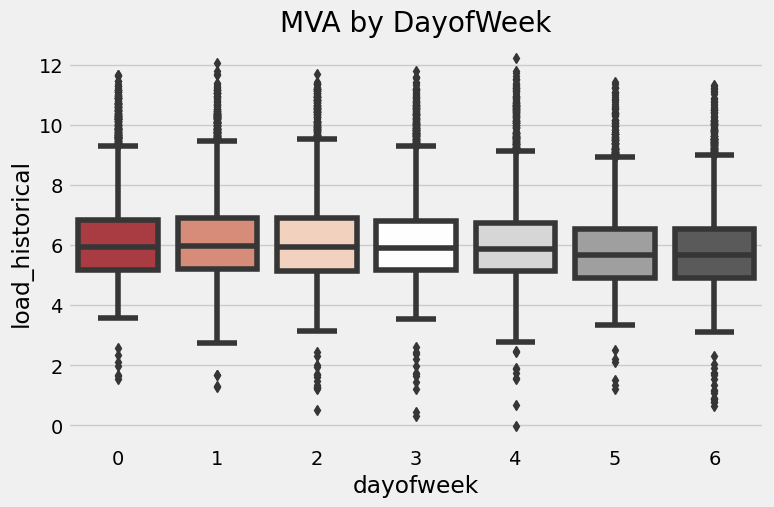

In [138]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_new, x='dayofweek', y='load_historical',palette='RdGy')
ax.set_title('MVA by DayofWeek')
plt.show()

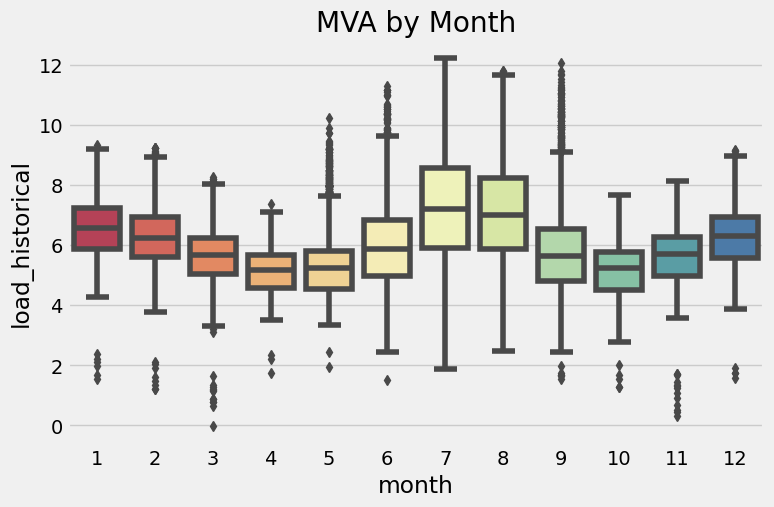

In [140]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=df_new, x='month', y='load_historical', palette='Spectral')
ax.set_title('MVA by Month')
plt.show()

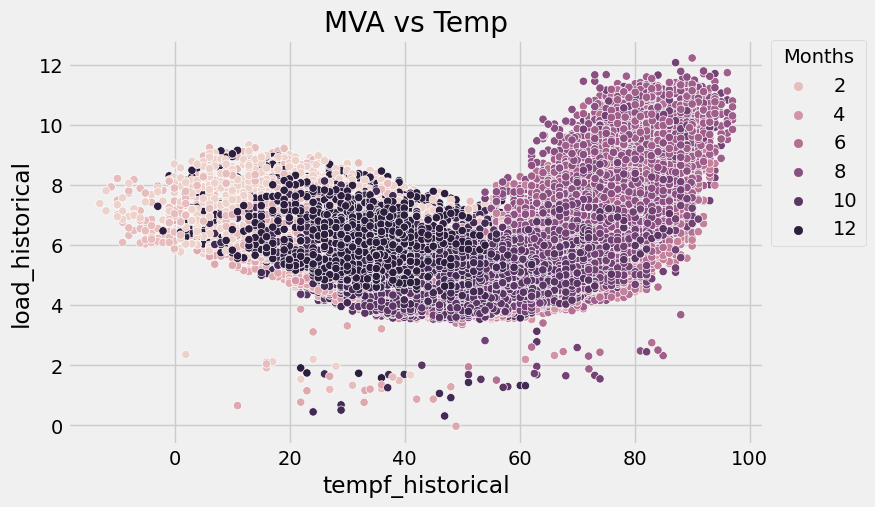

In [159]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(data=df_new, x='tempf_historical', y='load_historical', hue="month")
ax.set_title('MVA vs Temp')
plt.legend(title='Months',bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show()

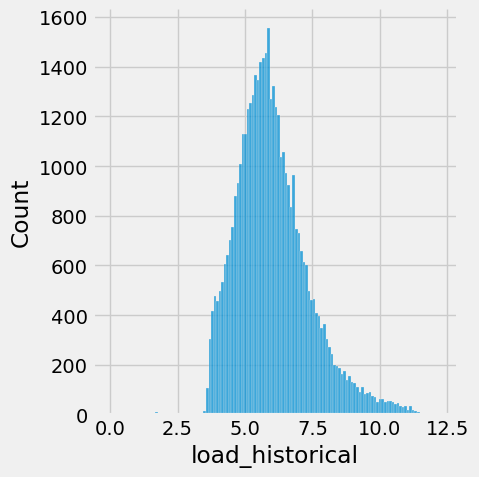

In [174]:
sns.displot(data=df_new, x='load_historical')
plt.show()

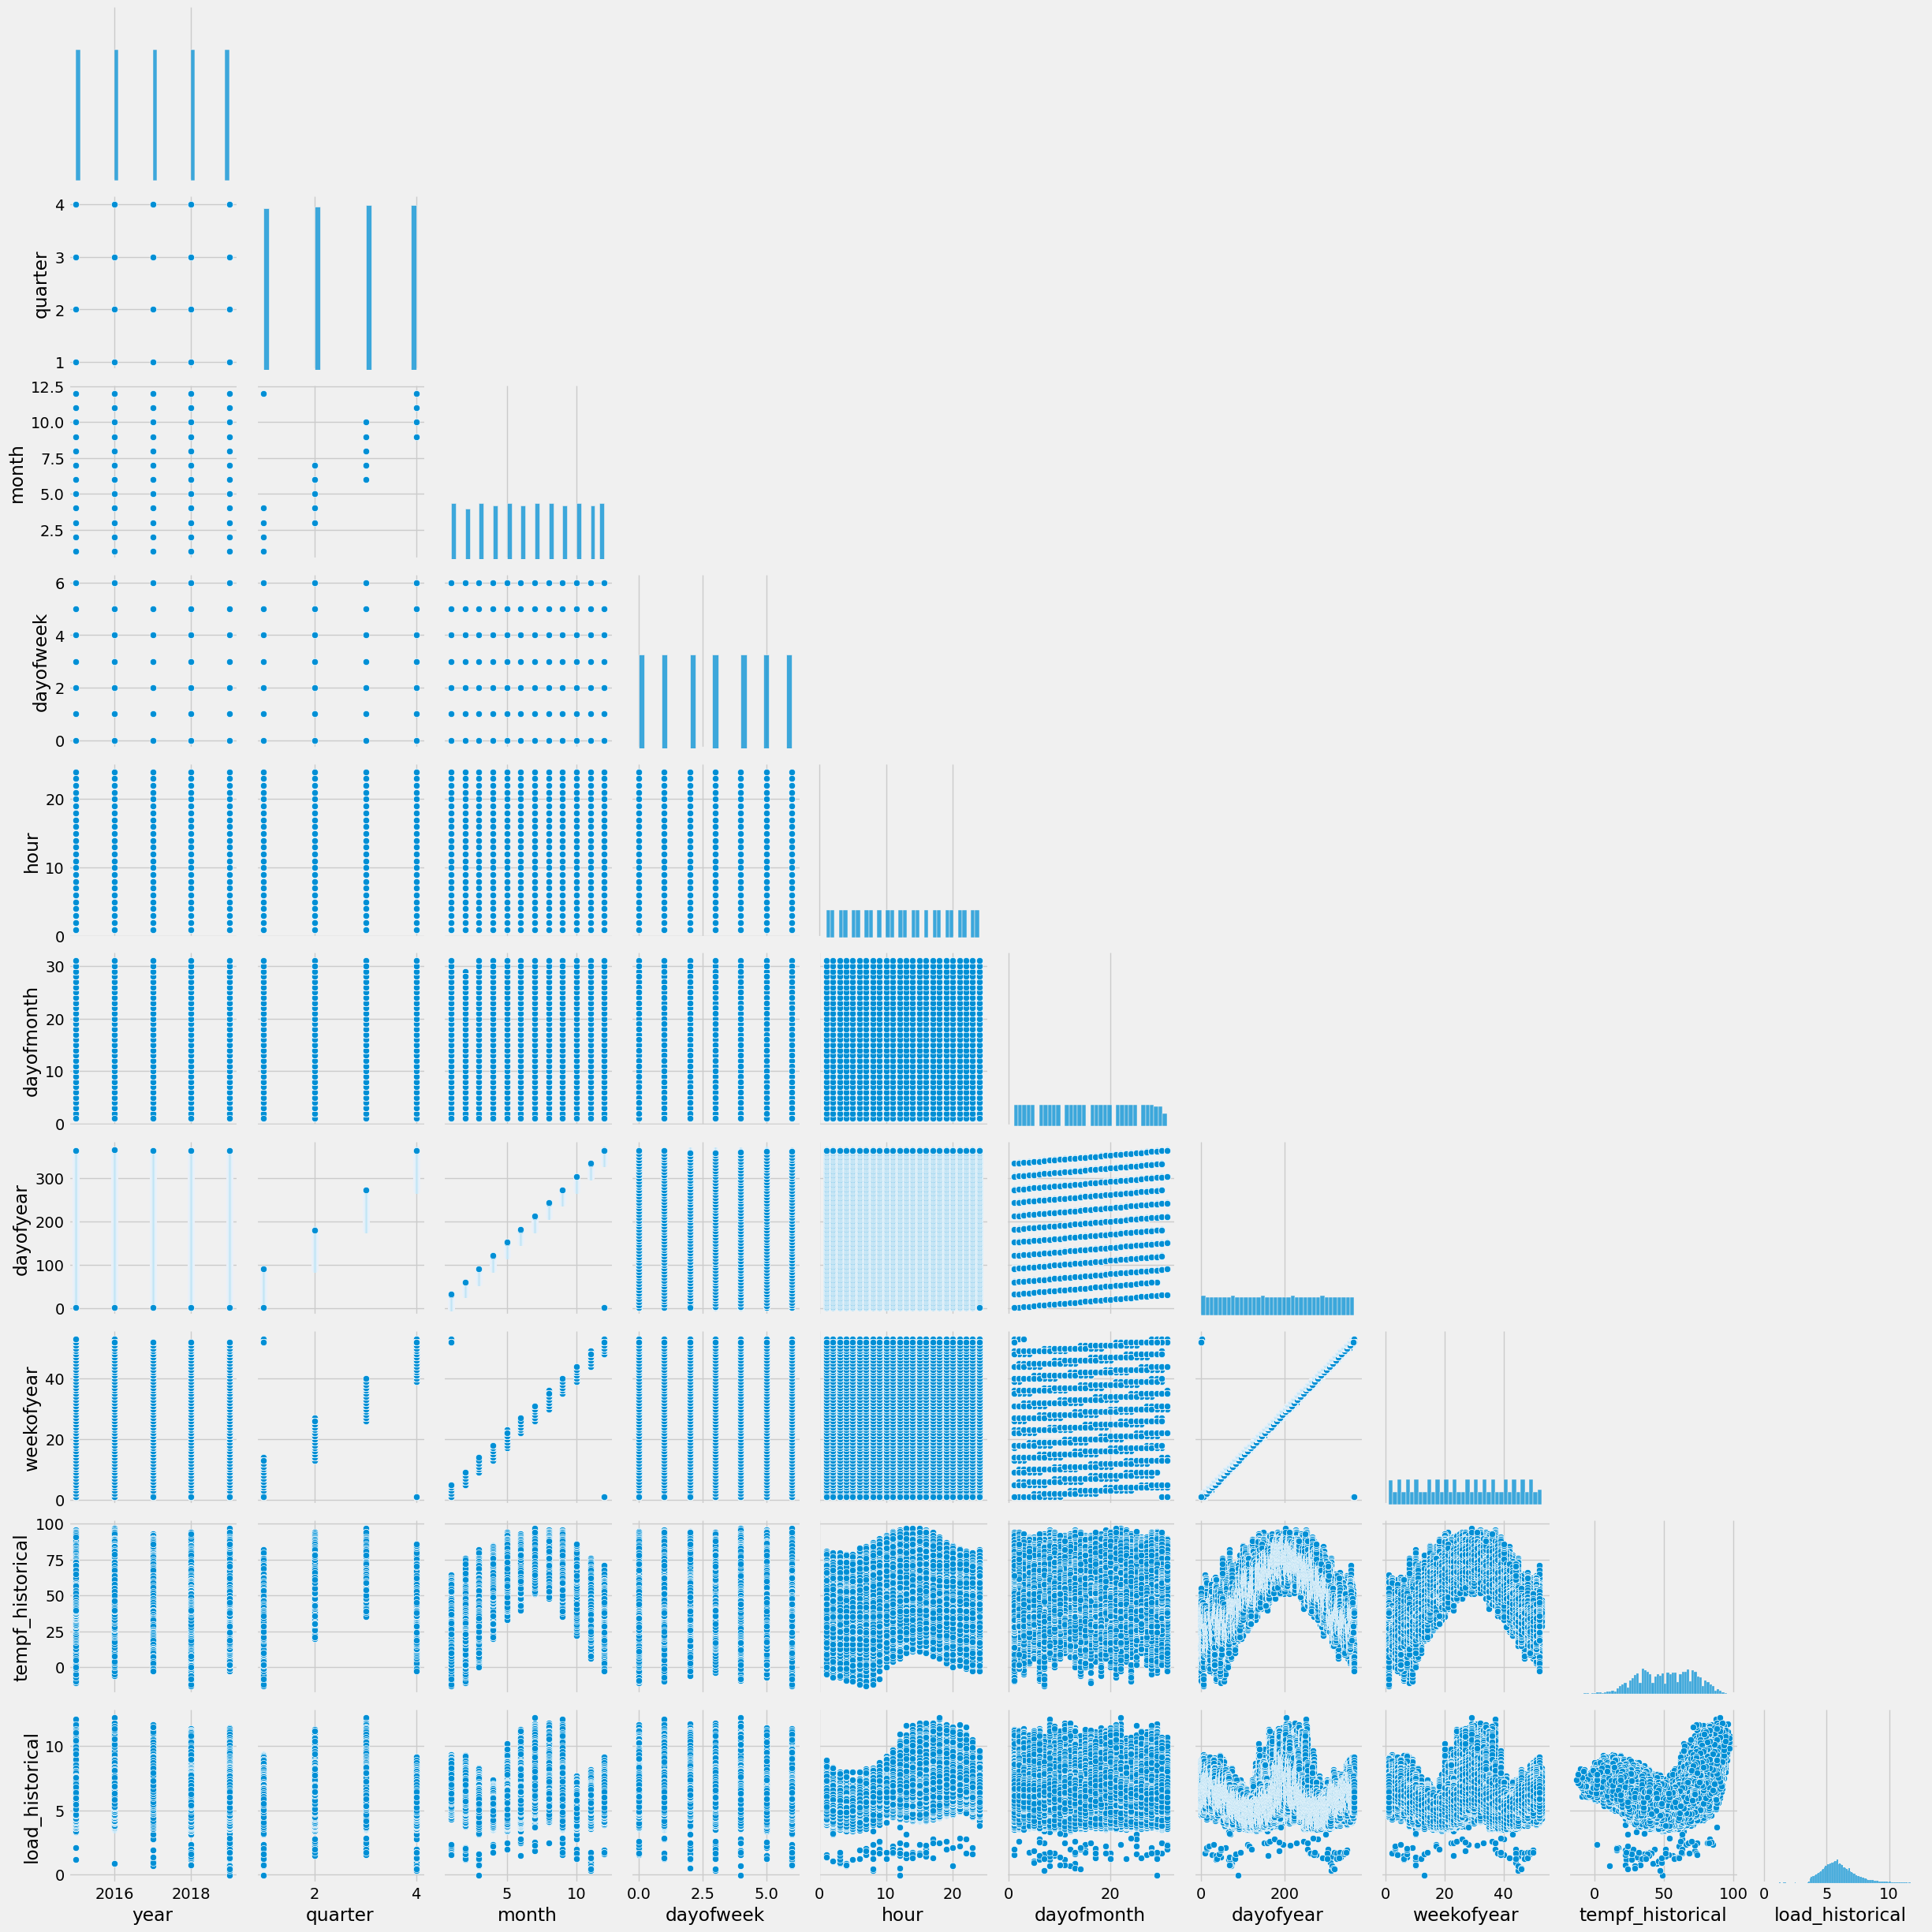

In [170]:
sns.pairplot(df_new, corner=True)
plt.show()

## Outlier Analysis:

    From the 'Historical and Predicted Data' plot from earlier, we can see that there are some outliers in our historal data, further confirmed from the displot above. There are 66 rows with energy use below 2.5 MVA. Removing those outliers results in a plot where out historical and predicted data look more closely related. We will use the outlier removed data for our model.

In [186]:
df_new.query('load_historical < 2.5')['load_historical']


time
2015-02-28 20:00:00    2.102165
2015-03-08 03:00:00    1.165132
2016-03-13 03:00:00    0.874703
2016-03-13 04:00:00    0.874703
2017-03-12 04:00:00    0.659462
                         ...   
2019-11-14 08:00:00    0.450396
2019-11-20 06:00:00    1.255476
2019-11-26 14:00:00    1.323024
2019-12-08 10:00:00    1.746724
2019-12-13 11:00:00    1.735443
Name: load_historical, Length: 66, dtype: float64

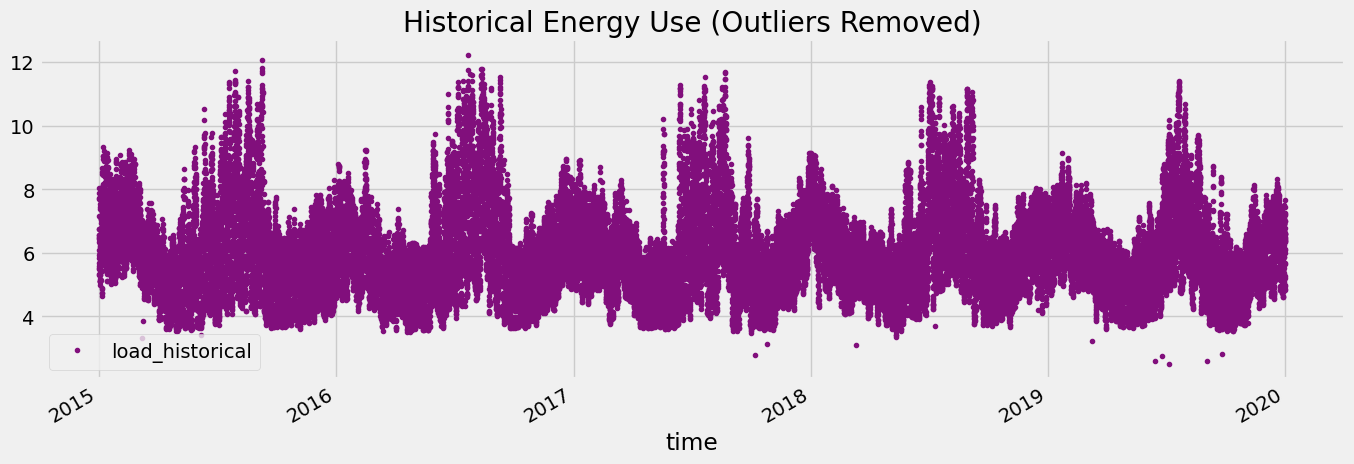

In [211]:
df_final = df_new.query('load_historical > 2.5')

df_final.plot(y='load_historical',
        use_index=True,
        style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Historical Energy Use (Outliers Removed)')
plt.show()

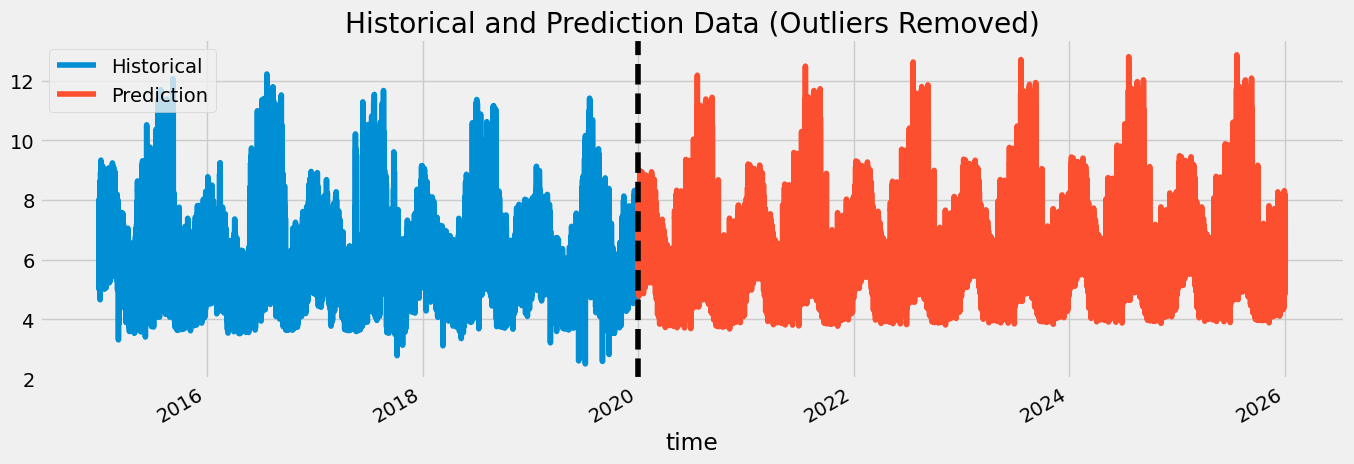

In [212]:
fig, ax = plt.subplots(figsize=(15, 5))
df_final.plot(y='load_historical',use_index=True, ax=ax, label='Historical Data', title='Historical and Prediction Data (Outliers Removed)')
df_fut.plot(y='load_p99', use_index=True, ax=ax, label='Predicition Data')
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Historical', 'Prediction'])
plt.show()

# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;;padding:10px;font-weight:bold">Training The Model <p/> 

## First, we will do a normal Train/Test Split:

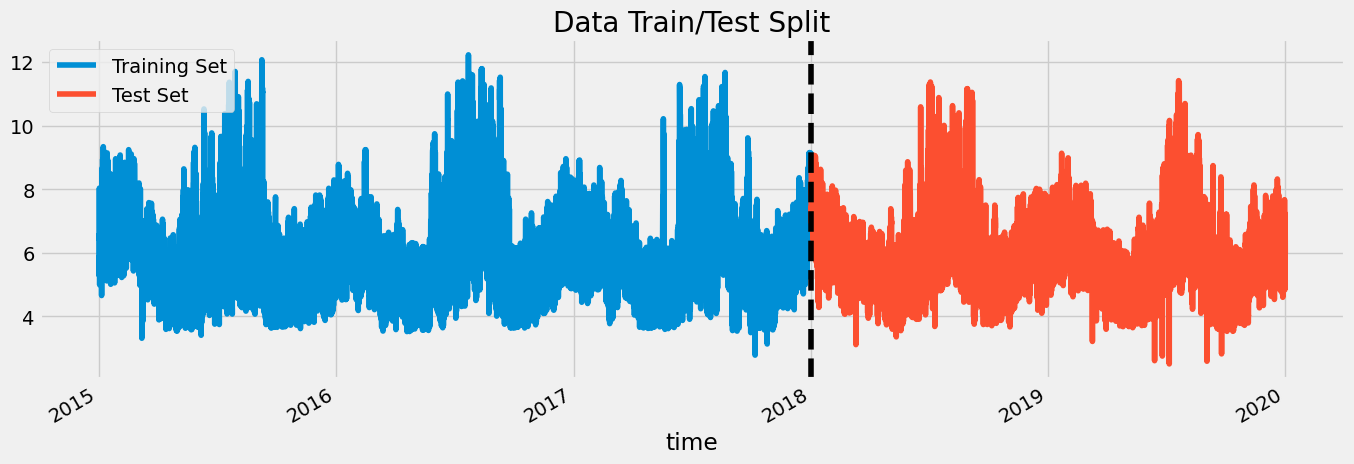

In [246]:
train = df_final.loc[df_final.index < '01-01-2018']
test = df_final.loc[df_final.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(y='load_historical',ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(y='load_historical',ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## 1st Model:

In [255]:
FEATURES = ['year', 'quarter', 'month', 'dayofweek', 'hour', 'dayofmonth',
            'dayofyear', 'weekofyear', 'tempf_historical']

TARGET = ['load_historical']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test  = test[FEATURES]
y_test  = test[TARGET]

xgb = XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
                       objective='reg:linear',max_depth=3, learning_rate=0.01)
    
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)], verbose=100)
    
y_pred = xgb.predict(X_test)

[15:10:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.65733	validation_1-rmse:5.60843
[100]	validation_0-rmse:2.23675	validation_1-rmse:2.17329
[200]	validation_0-rmse:1.10151	validation_1-rmse:1.01354
[300]	validation_0-rmse:0.77681	validation_1-rmse:0.67725
[400]	validation_0-rmse:0.68021	validation_1-rmse:0.58540
[500]	validation_0-rmse:0.64191	validation_1-rmse:0.55558
[600]	validation_0-rmse:0.61896	validation_1-rmse:0.54112
[700]	validation_0-rmse:0.60412	validation_1-rmse:0.53153
[800]	validation_0-rmse:0.59164	validation_1-rmse:0.52513
[900]	validation_0-rmse:0.58107	validation_1-rmse:0.52156
[999]	validation_0-rmse:0.57175	validation_1-rmse:0.52023


In [280]:
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))
RSQUARED = metrics.r2_score(y_test,y_pred)

print('RMSE: ',round(RMSE,4))
print('R2: ',round(RSQUARED, 2)*100,'%')

RMSE:  0.5202
R2:  83.0 %


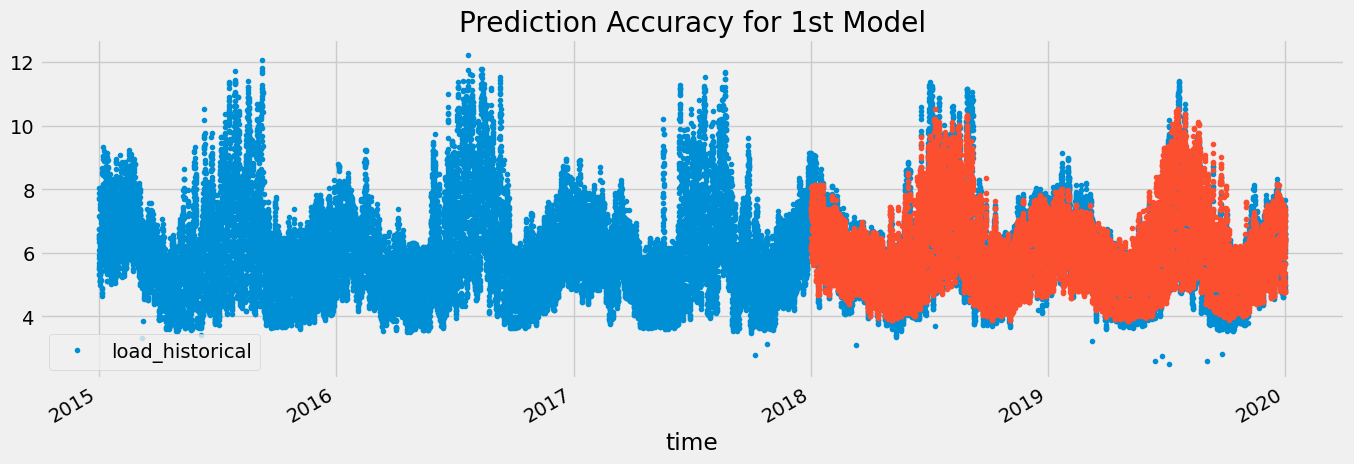

In [268]:
test['prediction'] = y_pred
            
ax = df_final.plot(y='load_historical',
        use_index=True,
        style='.',
        figsize=(15, 5),
        title='Prediction Accuracy for 1st Model')

test['prediction'].plot(y='load_historical',
        use_index=True,
        style='.')


plt.show()

## Now we will Split the Data for Cross Validation:

In [213]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*182, gap=24)
df_final = df_final.sort_index()

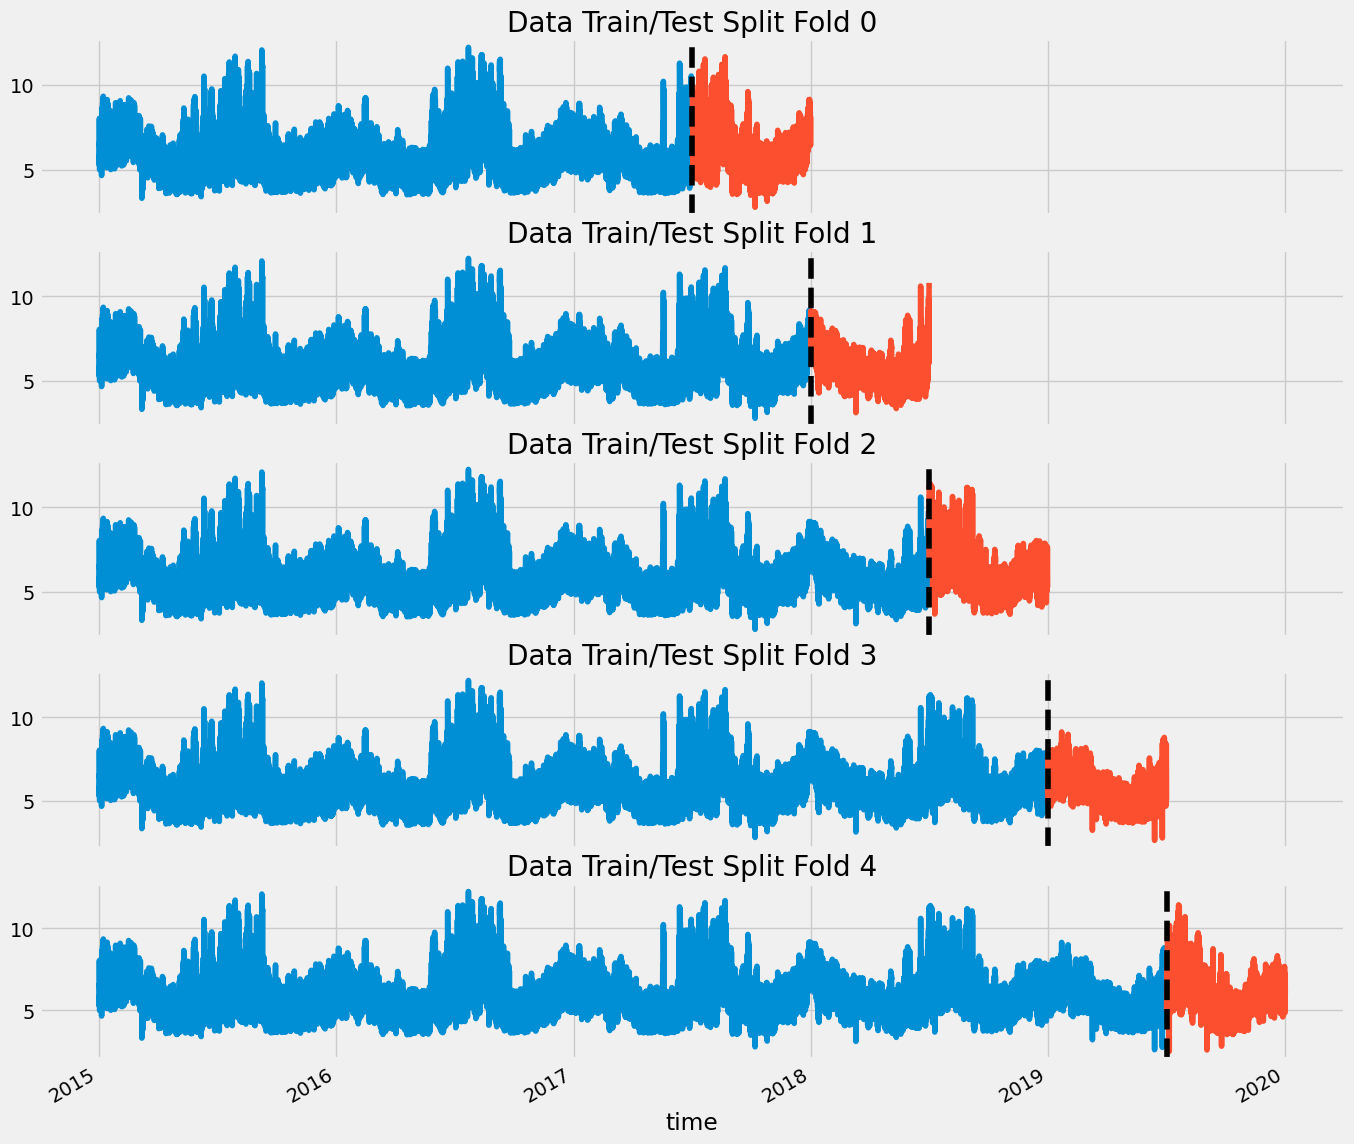

In [217]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_final):
    train = df_final.iloc[train_idx]
    test = df_final.iloc[val_idx]
    train['load_historical'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['load_historical'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
    

    

## Training the CV Model:

In [283]:
fold = 0
preds = []
scores = []
r2_scores = []
for train_idx, val_idx in tss.split(df_final):
    train = df_final.iloc[train_idx]
    test = df_final.iloc[val_idx]
    
    FEATURES = ['year', 'quarter', 'month', 'dayofweek', 'hour', 'dayofmonth',
               'dayofyear', 'weekofyear', 'tempf_historical']
    TARGET = ['load_historical']
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test  = test[FEATURES]
    y_test  = test[TARGET]
    
    reg = XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
                           early_stopping_rounds=50, objective='reg:linear',
                           max_depth=3, learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test,y_test)], verbose=1000)
    
    y_pred = reg.predict(X_test)
    
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)
    r2_score = metrics.r2_score(y_test,y_pred)
    r2_scores.append(r2_score)

[15:22:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.62088	validation_1-rmse:5.82468
[999]	validation_0-rmse:0.55236	validation_1-rmse:0.68146
[15:22:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.65481	validation_1-rmse:5.42510
[999]	validation_0-rmse:0.56872	validation_1-rmse:0.47145
[15:22:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.62198	validation_1-rmse:6.00497
[999]	validation_0-rmse:0.55828	validation_1-rmse:0.55450
[15:22:36] WA

In [284]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

print('---------------------------------------------')

print(f'r2 across folds: {np.mean(r2_scores)}')
print(f'Fold r2 scores: {r2_scores}')

Score across folds 0.5443
Fold scores:[0.6814623030886205, 0.47144368109776225, 0.5542116851226909, 0.42781662587741853, 0.5867692713684505]
---------------------------------------------
r2 across folds: 0.8215132547685521
Fold r2 scores: [0.7894494638387508, 0.8189416001049663, 0.858557948610738, 0.8266355290653388, 0.8139817322229663]


# <p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;;padding:10px;font-weight:bold">Predicting the Future <p/> 

In [309]:
# Note: temp was removed as a feature since we don't have temp in the future data
FEATURES = ['year', 'quarter', 'month', 'dayofweek', 'hour', 'dayofmonth',
            'dayofyear', 'weekofyear']

TARGET = ['load_historical']

X = df_final[FEATURES]
y = df_final[TARGET]



xgb = XGBRegressor(base_score=0.5, booster='gbtree', n_estimators=1000,
                       objective='reg:linear',max_depth=3, learning_rate=0.01)
    
xgb.fit(X, y, eval_set=[(X,y)], verbose=100)

[15:44:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.63803
[100]	validation_0-rmse:2.23994
[200]	validation_0-rmse:1.14926
[300]	validation_0-rmse:0.86180
[400]	validation_0-rmse:0.78776
[500]	validation_0-rmse:0.76005
[600]	validation_0-rmse:0.74342
[700]	validation_0-rmse:0.73082
[800]	validation_0-rmse:0.72127
[900]	validation_0-rmse:0.71395
[999]	validation_0-rmse:0.70706


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

In [288]:
df_final.index.max()

Timestamp('2019-12-31 23:00:00')

In [324]:
future = pd.date_range('2020-01-01', '2026-01-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
future_df = create_features(future_df)
future_df['weekofyear'] = future_df['weekofyear'].astype(int)


#past_df = df_final.copy()
#past_df['isFuture'] = False
#past_and_future = pd.concat([past_df,future_df])

In [325]:
future_df['pred'] = xgb.predict(future_df[FEATURES])

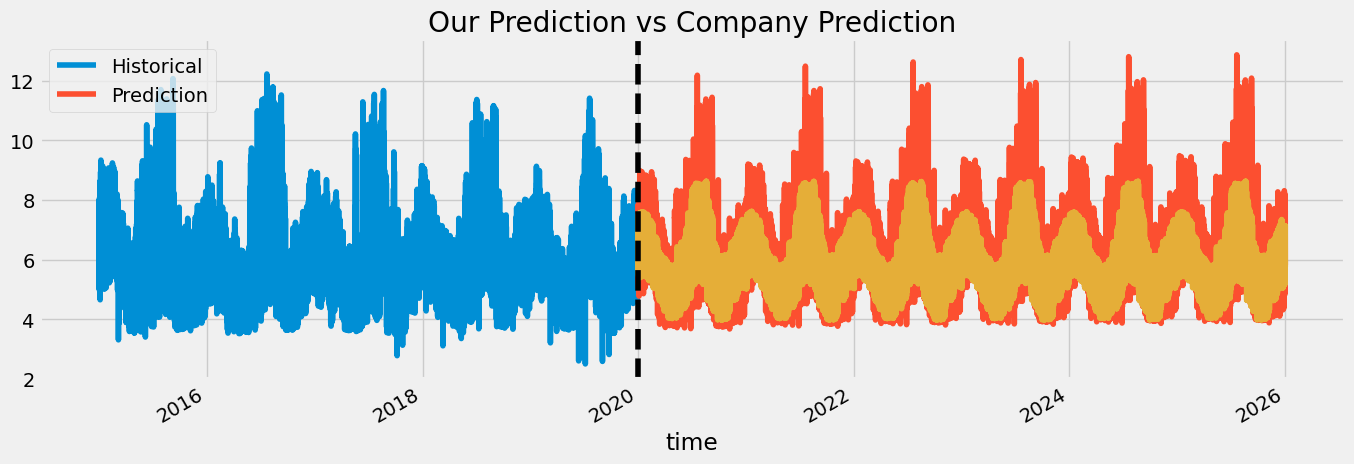

In [326]:
fig, ax = plt.subplots(figsize=(15, 5))
df_final.plot(y='load_historical',use_index=True, ax=ax, label='Historical Data', title='Our Prediction vs Company Prediction')
df_fut.plot(y='load_p99', use_index=True, ax=ax, label='Predicition Data')
future_df['pred'].plot(ax=ax)
ax.axvline('01-01-2020', color='black', ls='--')
ax.legend(['Historical', 'Prediction'])
plt.show()

In [331]:
r2_score(df_fut['load_p99'],future_df['pred'][1:])

0.5982354610454979

## Results:

    Our original/CV models both had high prediction accuracy with a R2 of about 83%. The predictions for the future are not matching the company predictions, we are getting and R2 of about 60%. This can be due to several factors. First, we don't know what model the company used to make these pedictions. Second, we had to remove temperature as feature, since we don't have that information in our data. We can try filling in the temperatures by calulating the mean temperature for previous years, and see if that brings us closer to the company predictions.